In [1]:
%matplotlib notebook
import helpers
import numpy as np
import pandas as pd
import subject_DM
import statsmodels.api as sm
import seaborn as sns

Loaded entropies from file (S=15000, entropy_bins=50)!
Loaded dot-level measures from file (S=2000, Smin=20)!


In [10]:
r_names = ['dot_y', 'surprise', 'dot_x', 'entropy', 'trial_time', 
           'intercept']
dots = np.arange(1, 6)
rt_thresh = 0.1

if 'RT' in r_names:
    DM = subject_DM.get_trial_DM(dots, r_names=r_names)
else:
    DM = subject_DM.get_trial_DM(dots, r_names=r_names+['RT'])
    
DM = DM.loc(axis=0)[subjects, :]

# ensure that order of regressors in design matrix and results DataFrame 
# (second_level) is the same
DM.sort_index(axis=1, inplace=True)

# remove trials which had too few simulations to estimate surprise
snames = ['surprise_%d' % d for d in dots]
good_trials = np.logical_not(np.any(np.isnan(DM[snames]), axis=1))
                         
# remove trials which had RTs below a threshold (and therefore most likely 
# cannot have an effect of the last considered dot)
good_trials = np.logical_and(good_trials, 
                             DM['RT'] >= helpers.dotdt*(dots.max()-1) + rt_thresh)
# remove RT from design matrix
if 'RT' not in r_names:
    del DM['RT']

# final number of regressors
R = DM.shape[1]

# select only the good trials
DM = DM.loc[good_trials]

# normalise
DM = (DM - DM.mean()) / DM.std()
# intercept will be nan, because it has no variance
DM['intercept'] = 1

In [89]:
time = 700

epochs_all = helpers.load_meg_epochs(hfreq=100, window=[time/1000, time/1000], bl=(-0.3, 0))
subjects = epochs_all.index.levels[0]
S = subjects.size

times = epochs_all.index.levels[2]

# epochs_all = (epochs_all - epochs_all.mean()) / epochs_all.std()

In [90]:
data = epochs_all.MEG0721
data = data.loc[good_trials.values]

In [91]:
reg = 'dot_x_4'
regi = DM.columns == reg
regremi = np.logical_not(regi)

resid = pd.DataFrame([], index=data.index, columns=['residual', reg])
params = np.zeros((S, R))
for s, sub in enumerate(subjects):
    subdata = data.loc[sub].values
    DMsub = DM.loc[sub].values
    res = sm.OLS(subdata, DMsub, hasconst=True).fit()
    
    resid.loc[(sub, slice(None), time), 'residual'] = subdata - np.dot(DMsub[:, regremi], res.params[regremi])
    resid.loc[(sub, slice(None), time), reg] = DM.loc[sub, reg].values
    
    params[s, :] = res.params

In [87]:
res.f_pvalue

0.047877789577690372

<IPython.core.display.Javascript object>


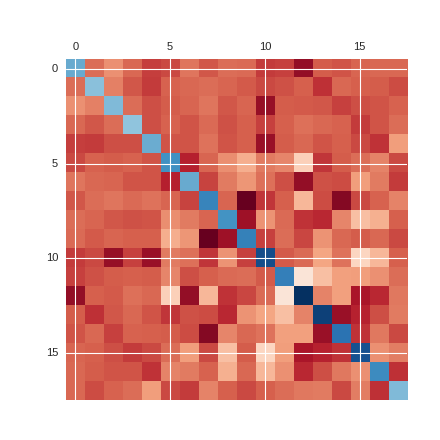

0        dot_x_1
1        dot_x_2
2        dot_x_3
3        dot_x_4
4        dot_x_5
5        dot_y_1
6        dot_y_2
7        dot_y_3
8        dot_y_4
9        dot_y_5
10       entropy
11     intercept
12    surprise_1
13    surprise_2
14    surprise_3
15    surprise_4
16    surprise_5
17    trial_time
dtype: object

In [82]:
sns.plt.matshow(res.cov_params(), cmap='RdBu');
pd.Series(DM.columns)

<IPython.core.display.Javascript object>


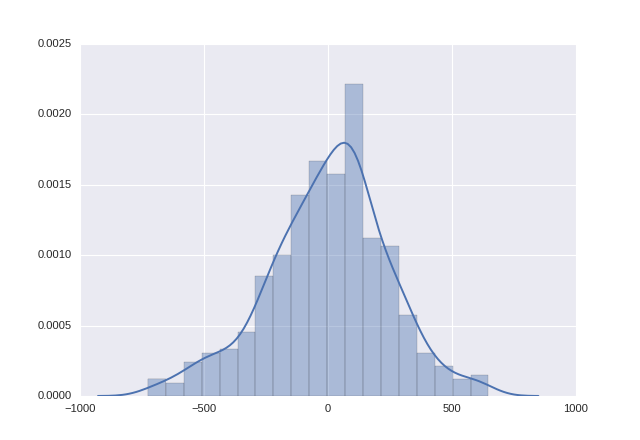

/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [92]:
sns.plt.figure()
sns.distplot(res.resid)

In [93]:
pd.DataFrame(params[:, regi], index=subjects)

,0
subject,
2,50.691781
3,30.089446
4,49.349872
5,23.828910
6,29.319238
7,21.699718
8,25.645911
9,40.715632
10,36.770800


<IPython.core.display.Javascript object>


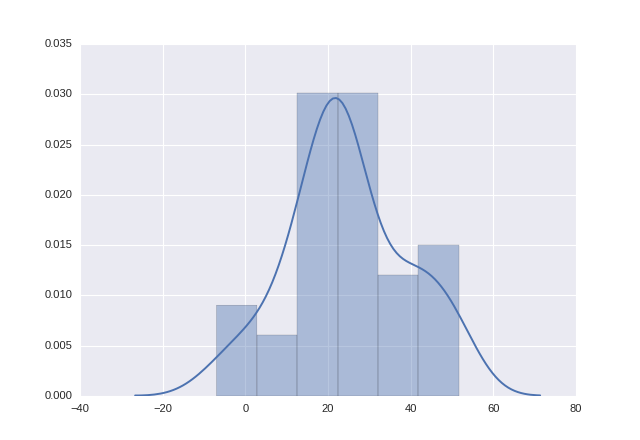

/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [94]:
sns.plt.figure()
sns.distplot(params[:, regi])

<IPython.core.display.Javascript object>


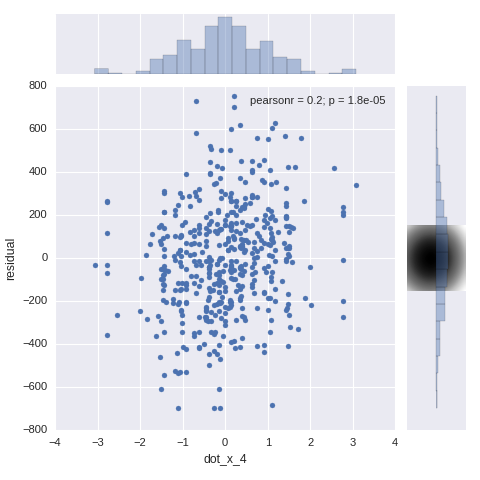

In [95]:
sns.jointplot(reg, 'residual', data=resid.loc[4])

In [96]:
import scipy.stats
scipy.stats.spearmanr(resid.values)

SpearmanrResult(correlation=0.10298786939185976, pvalue=3.7698008459362253e-39)

In [143]:
x, y = np.meshgrid(np.linspace(-150, 150, 1000), np.linspace(-150, 150, 1000))

model = helpers.get_ideal_observer(np.c_[x.flatten(), y.flatten()].T[None, :, :])
model = helpers.get_ideal_observer(np.zeros((1, 2, 2000)))
model.noisestd = 70

In [157]:
log_post, log_liks = model.compute_logpost_from_features(np.arange(model.L))
surprise = model.compute_surprise(log_post, log_liks)

In [190]:
flipped_trials = np.arange(1, 240-72 + 1)
surprises = ['surprise_%d' % d for d in dots]
surprise_diff = pd.DataFrame(DM.loc[(2, slice(1, 168)), surprises].values - 
        DM.loc[(2, slice(241, 240+168)), surprises].values, columns=surprises)
surprise_diff.describe()

,surprise_1,surprise_2,surprise_3,surprise_4,surprise_5
count,168.000000,168.000000,168.000000,168.000000,168.000000
mean,-0.005644,-0.002850,0.021376,0.014134,-0.001703
std,0.195409,0.097332,0.082089,0.071719,0.067424
min,-0.425824,-0.280650,-0.103456,-0.200806,-0.204053
25%,-0.166076,-0.057362,-0.035256,-0.032049,-0.047736
50%,-0.010842,0.003580,0.004309,0.008906,-0.002110
75%,0.140758,0.060597,0.064533,0.054224,0.044183
max,0.509282,0.276127,0.332853,0.302930,0.180276


<IPython.core.display.Javascript object>


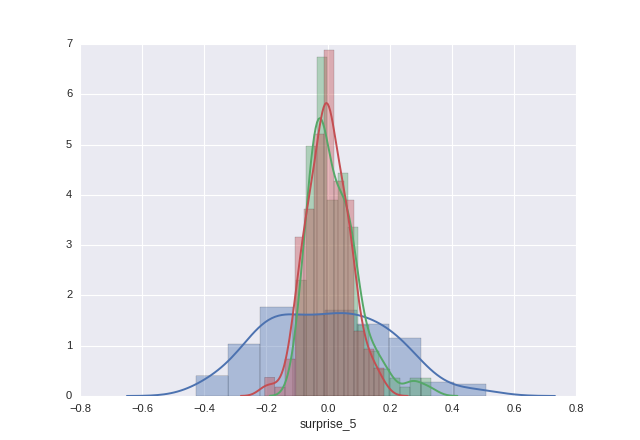

/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [191]:
sns.plt.figure()
sns.distplot(surprise_diff.surprise_1)
sns.distplot(surprise_diff.surprise_3)
sns.distplot(surprise_diff.surprise_5)

In [166]:
DM_raw.loc[(2, [1, 2, 3, 4, 5, 241, 242, 243, 244, 245]), ['dot_y_1', 'dot_x_1', 'dot_y_2', 'dot_x_2', 'surprise_1', 'surprise_2']]

dot_y_1  dot_x_1  dot_y_2  dot_x_2  surprise_1  surprise_2
subject trial                                                            
2       1         -7.0     12.0     -7.0    -32.0   11.903204   11.304186
        2          4.0    -67.0     -2.0     88.0   12.212563   12.126974
        3        -99.0     71.0    -72.0    -10.0   13.425048   11.732567
        4        -88.0    -35.0     53.0     23.0   12.709270   11.580811
        5        -47.0    -22.0   -108.0     25.0   12.137067   12.488756
        241       -7.0    -12.0     -7.0     32.0   11.850350   11.287186
        242        4.0     67.0     -2.0    -88.0   12.375591   12.012614
        243      -99.0    -71.0    -72.0     10.0   13.179994   11.810612
        244      -88.0     35.0     53.0    -23.0   12.813520   11.564458
        245      -47.0     22.0   -108.0    -25.0   12.170159   12.474581

In [158]:
surprise[0, :, 0].mean()

12.044522583938585

<IPython.core.display.Javascript object>


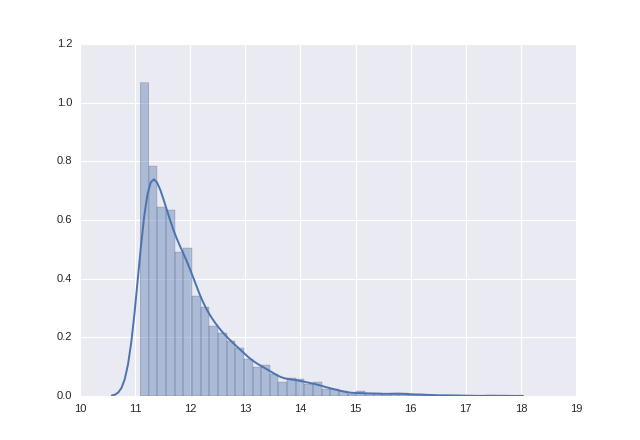

/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [145]:
sns.plt.figure()
sns.distplot(surprise[0, :, 0])

In [115]:
ll_left = log_liks[0, 0, :, 0].reshape(1000, 1000)
ll_right = log_liks[0, 1, :, 0].reshape(1000, 1000)
surprise = surprise[0, :, 0].reshape(1000, 1000)

<IPython.core.display.Javascript object>


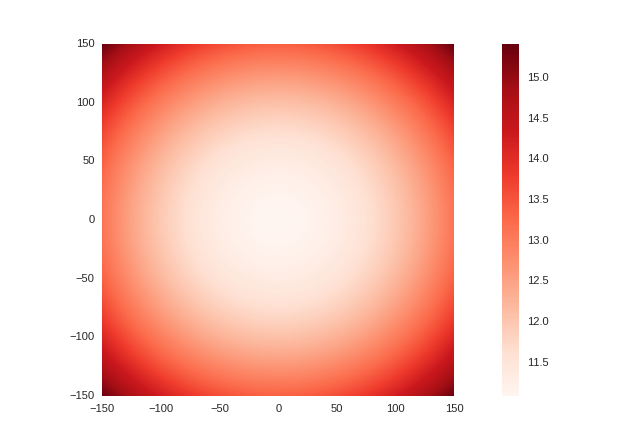

In [116]:
sns.plt.figure()
sns.plt.pcolormesh(x, y, surprise, cmap='Reds')
sns.plt.colorbar()
sns.plt.axis('square');

In [125]:
dot_x_1 = -25
delta = 5

DM_raw = subject_DM.get_trial_DM(dots, r_names=r_names)
ind = np.abs(DM_raw.dot_x_1 - dot_x_1) < delta

<IPython.core.display.Javascript object>


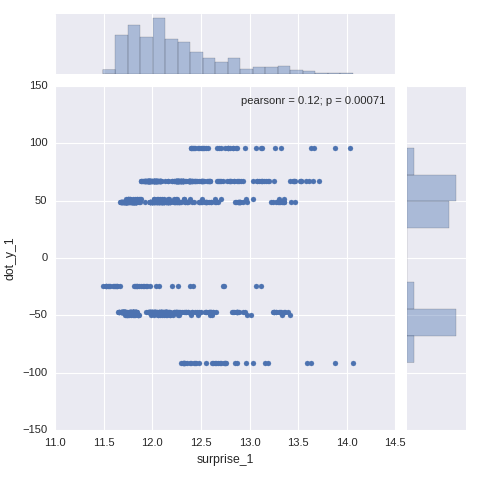

In [130]:
sns.jointplot('surprise_1', 'dot_y_1', data=DM_raw[ind])

<IPython.core.display.Javascript object>


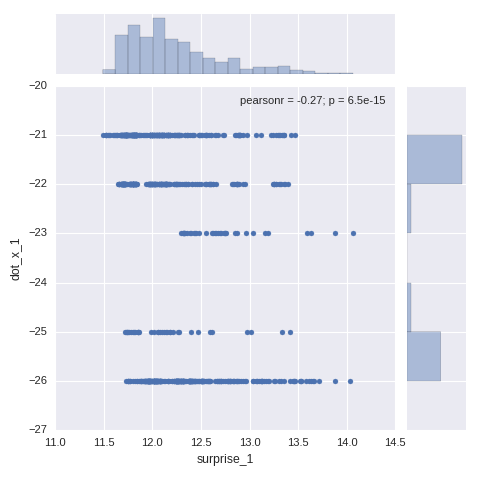

In [135]:
sns.jointplot('surprise_1', 'dot_x_1', data=DM_raw[ind])

<IPython.core.display.Javascript object>


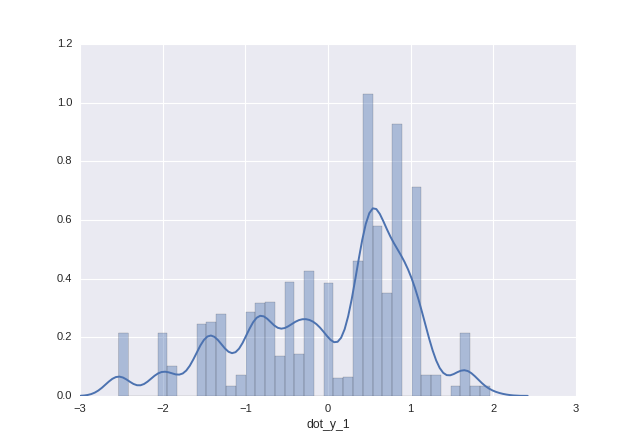

/home/bitzer/programs/anaconda/envs/python3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


In [134]:
sns.plt.figure()
sns.distplot(DM.dot_y_1)